# Image Classification with Microsoft AI Platform
## Summary
Image classification is among the most popular applications of deep learning. For example, the insurance company can classify the car accidents based on the photo of the damaged part and make decision whether the claim is valid or not. For manufacturing factories, they may inspect whether there is defect in the product based on the images. For this project, we will use the images from the parts of the vehicle to judge whether there is a defect with it, such as dents or scratches on the surface. Microsoft’s Azure cloud ecosystem provides the scalable, elastic and intelligent AI platform. We will demonstrate how to develop the end to end AI solution with Azure AI platform. The solution will include:

- Image processing: process the images for feature extraction;
- Deep learning model: building a CNN (Convolutional Neural Networks);
- Model training: show how to create a CNN to train the model;
- Transfer learning: using pre-trained deep learning model to fine tune the new model;
- Deploy the model as a web service: demonstrate how to deploy the trained model as a web service;
- Consume the web service: How to invoke the model;
- PowerBI dashboard: building a dashboard to track the performance

### Import the required packages

In [38]:
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import skimage.feature
import imutils

### Label the image
There are four sub-folders under the Images folder. The Train and Test folders are the train and test images from the original dataset. These images are taken with various sizes. The sub-folders Train_dotted and Test_dotted are the same images with Train and Test sub-folders except the red blods are added manually into the images to mark our the center of the dents or defects. 
Image classification is the same as the common classificaiton problem. First we need label the data. What we did here is to compare the same images from Train/Test with that in Train_dotted/Test_dotted to find our the center of the dents or defects. Then cut off the 64X64 around the center. This one will be labeld as '1'. For the rest of the images, we will cut 64X64 images randomly and label them as '0'. By doing so, we can add both positive and negative cases. The following picture showed this proces:

<img src="picture_processing.jpg" alt="Alt text that describes the graphic" title="Image labeling process" />

In [39]:
# Loop through each image
def imgProcess( filePath, dottedFilePath, walkSize ):
    imgs = []
    labels = []
    file_names = os.listdir(filePath)
    print(file_names)
    for filename in file_names:
        image_1 = cv2.imread(dottedFilePath + filename)
        image_2 = cv2.imread(filePath + filename)
        height, width = image_1.shape[:2]
        cut = np.copy(image_2)

        # absolute difference between the orignal and the dotted
        image_3 = cv2.absdiff(image_1,image_2)
        # mask out blackened regions from the dotted images
        mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        mask_1[mask_1 < 20] = 0
        mask_1[mask_1 > 0] = 255

        mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
        mask_2[mask_2 < 20] = 0
        mask_2[mask_2 > 0] = 255

        image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
        image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 

        # convert to grayscale to be accepted by skimage.feature.blob_log
        image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)

        # Detect the dotted defects in the dotted image
        blobs = skimage.feature.blob_log(image_3, min_sigma=6, max_sigma=8, num_sigma=2, threshold=0.04, overlap = 0.5)

        dents = []
        image_circles = image_1

        # For each file, identify the coordinates of all defects based on blobs
        for blob in blobs:
            # get the coordinates for each blob
            y, x, s = blob

            # get the color of the pixel from Train Dotted in the center of the blob
            g,b,r = image_1[int(y)][int(x)][:]

            # detect whether this is the defects center
            if r > 240 and g < 20 and b < 20: # RED
                dents.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (0,0,255), 10)    
  
            cv2.rectangle(cut, (int(x)-32,int(y)-32),(int(x)+32,int(y)+32), 0,-1)  

        # For each blob, find the positive case
        for coordinates in dents:        
            thumb = image_2[coordinates[1]-32:coordinates[1]+32,coordinates[0]-32:coordinates[0]+32,:]
            if np.shape(thumb) == (64, 64, 3):
                imgs.append(thumb)
                labels.append('1')
        # Expand the samples by finding more negative samples           
        for i in range(0,np.shape(cut)[0],walkSize):
            for j in range(0,np.shape(cut)[1],walkSize):                
                thumb = cut[i:i+64,j:j+64,:]
                if np.amin(cv2.cvtColor(thumb, cv2.COLOR_BGR2GRAY)) != 0:
                    if np.shape(thumb) == (64,64,3):
                        imgs.append(thumb)
                        labels.append('0')
    return imgs, labels

### Process train dataset
The images are splitted into train and test datasets. The test dataset will be reserved to test the model performance.

In [40]:
filePath = "images/Train/"
dottedFilePath = "images/Train_dotted/"
walkSize = 300
trainx, trainy = imgProcess(filePath, dottedFilePath, walkSize)

['img01.jpg', 'img02.jpg', 'img03.jpg', 'img04.jpg', 'img05.jpg', 'img06.jpg', 'img07.jpg', 'img08.JPG', 'img09.JPG', 'img10.JPG', 'img11.jpg', 'img12.jpg', 'img13.jpg', 'img14.jpg', 'img15.JPG']


In [41]:
print(len(trainx))
print(len(trainy))
print(trainy)

44
44
['1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0']


### Data Augmentation
Even with the image processed as before, still we have too few images for training (< 100). We need expand our dataset for a better model. Data Augmentation can always improve performance though the amount depends on the dataset. If you want to augmented the data to artificially increase the size of the dataset you can do the following if the case applies (it wouldn't apply if for example were images of houses or people where if you rotate them 180degrees they would lose all information but not if you flip them like a mirror does):

- rotation: random with angle between 0° and 360° (uniform)
- translation: random with shift between -10 and 10 pixels (uniform)
- rescaling: random with scale factor between 1/1.6 and 1.6 (log-uniform)
- flipping: yes or no (bernoulli)
- shearing: random with angle between -20° and 20° (uniform)
- stretching: random with stretch factor between 1/1.3 and 1.3 (log-uniform)
- mirroring: get the mirror of the original image

In our approach, we will rotate each images in every 15 degree, and then take the mirror of each image in horizontal and vertical directions. So for each image, we will generate 24 (rotated including the original one) * 2 (mirrored) = 48 images. The following picture illustrates the processing:

<img src="picture_augmentation.jpg" alt="Image augmentation" title="Image augmentation process" />

In [42]:
originx = np.copy(trainx)
originy = np.copy(trainy)
trainx = []
trainy = []   
    
for i in range(0,len(originx)):
    sample_image = originx[i]
    for rotated_angle in np.arange(0, 360, 15):
        rotated = imutils.rotate(sample_image, rotated_angle)
        trainx.append(rotated)
        trainy.append(originy[i])
        for flipped_angle in np.arange(0, 2):
            flipped_image = cv2.flip(rotated, flipped_angle)
            trainx.append(flipped_image)
            trainy.append(originy[i])

In [43]:
print((trainx[2].shape))
print(len(trainy))


(64, 64, 3)
3168


### Model training
We will use the Keras as example to show the model training process. Keras supports both CNTK and Tensorflow as the backend.
The problem we try to solve is verify whether the claim is accpeted or denied, which is a simply binary classification problem. Here we build a feed-forward convolutional neural network (CNN). It is similar to the LeNet, which performs quite well for this kind of classification problem. The following picture illustrates the workflow of the training process.

<img src="cnn_modeling.jpg" alt="Image augmentation" title="CNN Modeling Achitecture" />

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D, Input
from keras.utils import np_utils
from keras import optimizers
from collections import Counter
print(keras.__version__)

2.0.6


### Prepare data for training
We need transform the labels into one-hot encoder, i.e, for each labeled data will convert into two-column data:
<table style="width:65%">
  <tr>
    <th align=center>Id</th>
    <th align=center>Accepted</th>
    <th align=center>Denied</th>
  </tr>
  <tr>
    <td align=center >1</td>
    <td align=center >0</td>
    <td align=center >1</td>
  </tr>
  <tr>
    <td align=center >2</td>
    <td align=center >1</td>
    <td align=center >0</td>
  </tr>
<tr>
    <td align=center >3</td>
    <td align=center >0</td>
    <td align=center >1</td>
  </tr>
</table>

In [45]:
trainx = np.array(trainx)
trainy = np.array(trainy)

In [46]:
encoder = LabelBinarizer()
encoder.fit(trainy)
trainy = keras.utils.to_categorical(trainy, num_classes=2)

In [47]:
print(len(trainx), len(trainy))
print (trainx.shape)
print(trainy.shape)

3168 3168
(3168, 64, 64, 3)
(3168, 2)


### Prepare data for testing
To evaluate the performance of the model, we reserve some images for the final testing, which are not seen in the training.

In [48]:
filePath = "images/Test/"
dottedFilePath = "images/Test_dotted/"
walkSize = 300
testx, testy = imgProcess(filePath, dottedFilePath, walkSize)
testx = np.array(testx)
testy = np.array(testy)

['test01.jpg', 'test02.jpg', 'test03.jpg', 'test04.jpg', 'test05.jpg', 'test06.jpg', 'test07.jpg', 'test08.jpg', 'test09.jpg', 'test10.jpg', 'test11.jpg']


In [49]:
print(len(testx), len(testy))
print (testx.shape)
print(testy.shape)

25 25
(25, 64, 64, 3)
(25,)


In [50]:
print(testy)

['1' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '1' '0' '0' '1'
 '0' '0' '1' '1' '1' '0' '0']


### Create the model
The model is created with a slightly adaption of LeNet architecture, which consists five layers:

<b>Convolution -> Max pooling -> Convolution -> Max pooling -> 
Convolution -> Max pooling ->
Fullu connected -> Fully connected -> Softmax </b>

The model is tested and tuned with various parameter settings and the best one is chosen for final evaluation.

In [51]:
def createModel():    
    model = Sequential()

    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))


    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    opt = optimizers.Adam(decay = 0.1)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model


## Train the model from the scratch

In [62]:
mymodel = createModel()
seed = 123
numEpochs = 30
batchSize = 16
X_train, X_test, y_train, y_test = train_test_split(trainx, trainy, test_size=0.25, random_state=seed)
myhistory = mymodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=numEpochs, batch_size = batchSize, verbose=0)

In [63]:
def plotPerf(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

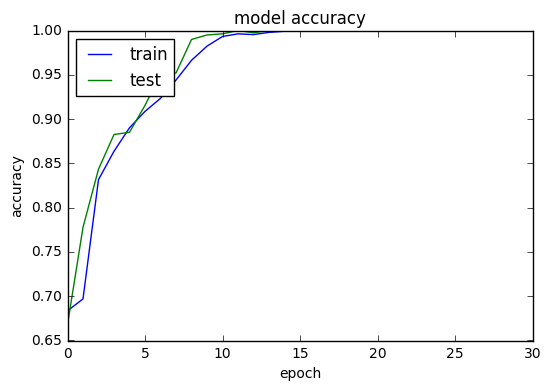

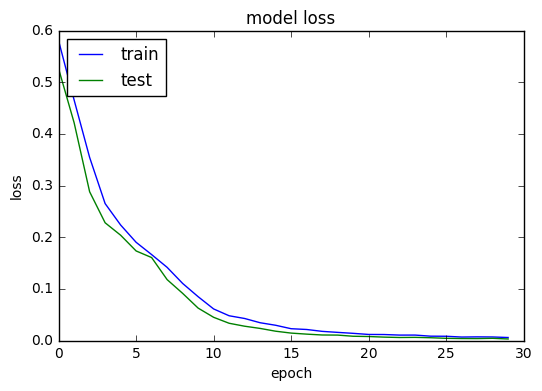

In [64]:
plotPerf(myhistory)

In [65]:
y_predicted = mymodel.predict(testx, verbose = 0)
y_pred = encoder.inverse_transform(y_predicted)
print("Predicted: \n", y_pred)
print("Actual: \n",testy)

Predicted: 
 ['0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '0' '0' '0']
Actual: 
 ['1' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '1' '0' '0' '1'
 '0' '0' '1' '1' '1' '0' '0']


0


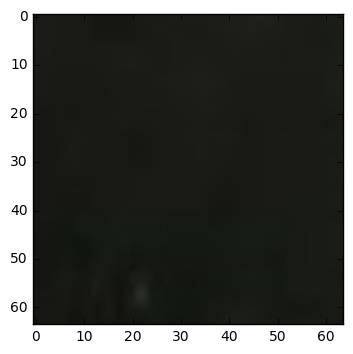

In [66]:
print(testy[5])
plt.imshow(cv2.cvtColor(testx[5], cv2.COLOR_BGR2RGB))
plt.show()

In [67]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
import pandas as pd
from ggplot import *

In [68]:
label_y = [int(numeric_string) for numeric_string in testy]
pred_y = [int(numeric_string) for numeric_string in y_pred]

# Confusion matrix
confusion = confusion_matrix(label_y, pred_y)
print(confusion)
# Precision 
precision_val = precision_score(label_y, pred_y, pos_label = 1)
# Recall
recall_val = recall_score(label_y, pred_y)
# F1 score
f1_val = f1_score(label_y,pred_y)

print("Precision: ", precision_val)
print("Recall   :", recall_val)
print("F1 score :", f1_val)

# Calculate AUC
fpr, tpr, _ = metrics.roc_curve(label_y, y_predicted[:,1])
auc = metrics.auc(fpr,tpr)
print("AUC      :", auc)

[[15  0]
 [ 4  6]]
Precision:  1.0
Recall   : 0.6
F1 score : 0.75
AUC      : 0.72


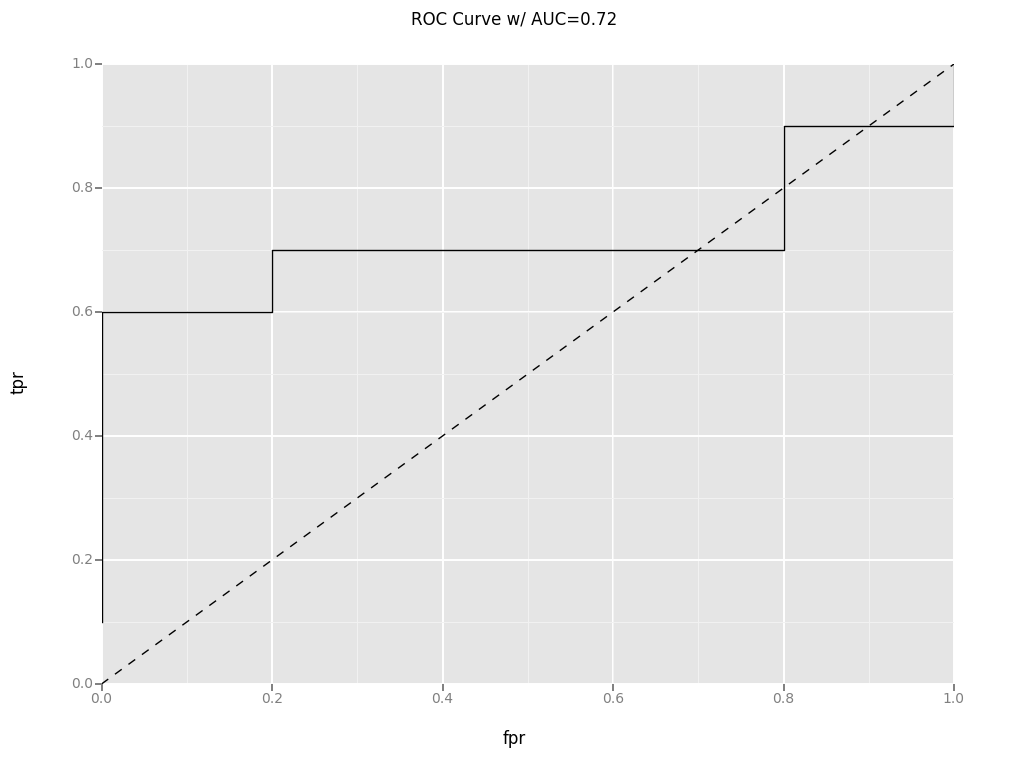

<ggplot: (-9223372014301045872)>

In [69]:
# Plot ROC curve
preds = y_predicted[:,1]
fpr, tpr, _ = metrics.roc_curve(label_y, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("ROC Curve w/ AUC=%s" % str(auc))

## Transfer learning
Given the small number of images we have, instead of training the model from the scratch, we may take advantage of pre-trained model. In general, the most important factors to decide how to perform transfer learning are the size of the new dataset (small or large) and the similarity with the original dataset. For our case, we will use the pre-trained mode with VGG16 as example to demonstrate the usage of transfer learning. Since the dataset is small, we will only train a linear classifier. Because the dataset is very different compared with the ImageNet images, we will train a classifier from activations somewhere earlier in the VGG16 network. 

In [54]:
from keras import applications
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [55]:
img_rows, img_cols, img_channel = 64, 64, 3
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [56]:
# Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
for layer in base_model.layers[:10]:
    layer.trainable = False

In [57]:
def createVGG16Model():
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(2, activation='softmax'))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    opt = optimizers.SGD(lr=1e-4, momentum=0.9)
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt,
                  metrics=['accuracy'])

    model.summary()
    return model

In [58]:
vgg16model = createVGG16Model()
vgghistory = vgg16model.fit(trainx, 
                           trainy, 
                           validation_split=0.25, 
                           epochs=10, 
                           batch_size=batchSize, 
                           verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [ ]:
plotPerf(vgghistory)

In [59]:
y_predicted = vgg16model.predict(testx, verbose=0)
y_pred = encoder.inverse_transform(y_predicted)
print("Predicted: \n", y_pred)
print("Actual: \n",testy)

Predicted: 
 ['0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '0' '0' '0']
Actual: 
 ['1' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '1' '0' '0' '1'
 '0' '0' '1' '1' '1' '0' '0']


In [60]:
print("Prediction: ", y_pred)
print("Acutal    : ", testy)
label_y = [int(numeric_string) for numeric_string in testy]
pred_y = [int(numeric_string) for numeric_string in y_pred]

# Confusion matrix
confusion = confusion_matrix(label_y, pred_y)
print(confusion)
# Precision 
precision_val = precision_score(label_y, pred_y, pos_label = 1)
# Recall
recall_val = recall_score(label_y, pred_y)
# F1 score
f1_val = f1_score(label_y,pred_y)

print("Precision: ", precision_val)
print("Recall   :", recall_val)
print("F1 score :", f1_val)


fpr, tpr, _ = metrics.roc_curve(label_y, y_predicted[:,1])
auc = metrics.auc(fpr,tpr)
print("AUC      :", auc)

Prediction:  ['0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '0' '0' '0']
Acutal    :  ['1' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0' '1' '0' '1' '0' '0' '1'
 '0' '0' '1' '1' '1' '0' '0']
[[15  0]
 [ 4  6]]
Precision:  1.0
Recall   : 0.6
F1 score : 0.75
AUC      : 0.906666666667


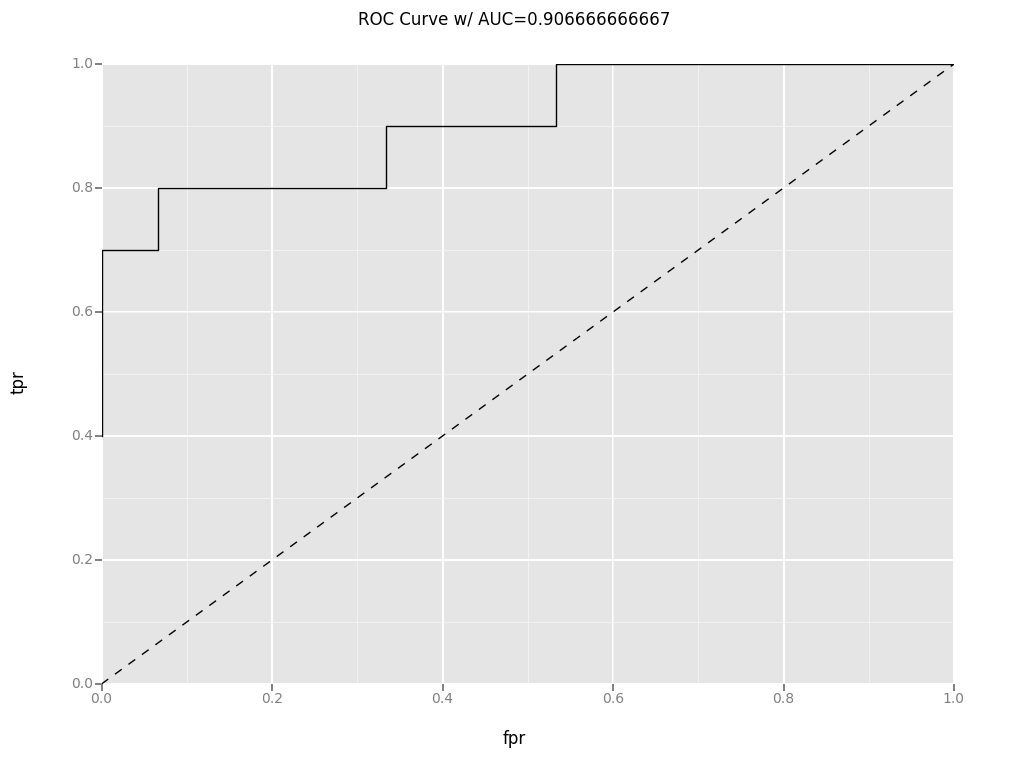

<ggplot: (22553535457)>

In [61]:
preds = y_predicted[:,1]
fpr, tpr, _ = metrics.roc_curve(label_y, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("ROC Curve w/ AUC=%s" % str(auc))

## Prepare for model deployment

Save Model into files. So it can be reload and used in inference prcess.

In [72]:
import h5py
model_json_string=mymodel.to_json()
open('my_model_architecture.json','w').write(model_json_string)
mymodel.save_weights('my_model_weights.h5')
print('saved!')

saved!
